# Introduction
**Scope**: The main target herein is to inspect the original dataset and adopt a simple exploratory method to build the optimum Shooting Guard profile, so as to benchmark the candidate players.

Along the way, we classify the variables in groups, according to their impact on our scope and conduct our investigation having in mind to maximise the variables of the crucial one (`group_1`). It turns out that we cannot rely on plain statistical methods to achieve our goal. We have to build better intuition on the existent data and use more advanced techniques, to effectively segment it and capture the underlying patterns, which may lead us to the best player.

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
%load_ext blackcellmagic
%config InlineBackend.figure_format = 'retina'

# 1. Read in data

In [2]:
# read in the data, shape and samples
plays_df = pd.read_csv("../notebooks/plays_17_18_19_train.csv",
                       converters={'GAME_ID': lambda x: str(x)})
print(plays_df.shape)
plays_df.head()

(74507, 33)


,GAME_ID,GAME_DATE,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE
0,0021700002,2017-10-17,1610612745,HOU,Houston,2772,Trevor Ariza,Trevor,F,NaN,37:39,107.3,111.3,121.4,121.3,-14.1,-10.0,0.152,5.00,33.3,0.023,0.156,0.079,6.7,0.444,0.444,0.109,0.111,103.83,101.99,84.99,80,0.063
1,0021700002,2017-10-17,1610612745,HOU,Houston,201583,Ryan Anderson,Ryan,F,NaN,33:17,117.8,127.4,119.4,119.7,-1.7,7.7,0.031,0.00,7.7,0.079,0.200,0.127,0.0,0.542,0.542,0.141,0.141,108.25,103.84,86.53,73,0.064
2,0021700002,2017-10-17,1610612745,HOU,Houston,203991,Clint Capela,Clint,C,NaN,18:10,95.4,95.1,153.0,155.0,-57.6,-59.9,0.000,0.00,0.0,0.050,0.250,0.125,16.7,0.600,0.575,0.267,0.273,107.54,107.01,89.17,41,0.092
3,0021700002,2017-10-17,1610612745,HOU,Houston,201935,James Harden,James,G,NaN,36:24,117.6,126.0,126.2,124.7,-8.6,1.3,0.440,3.67,28.2,0.024,0.185,0.088,7.7,0.522,0.545,0.308,0.309,104.52,101.54,84.62,77,0.134
4,0021700002,2017-10-17,1610612745,HOU,Houston,101108,Chris Paul,Chris,G,NaN,33:04,109.7,111.0,130.5,130.6,-20.8,-19.6,0.323,10.00,50.0,0.029,0.259,0.129,5.0,0.222,0.222,0.123,0.125,105.88,105.24,87.70,73,0.068


# 2. Data Cleaning
## 2.1 Drop Redundant Columns
In this very initial step, we should decide on the meaningful columns and drop the rest. That is, reason on the dataset by using domain knowledge. Speaking of dataset 'decluttering', all those columns have a 'E' prefix can be ignored as they are redundant. Also, `NET_RATING` can be calculated by the difference of `OFF_RATING` and `DEF_RATING`, while `COMMENT` does not contain any objective information.

In [3]:
# drop redundant columns
plays_df.drop(
    columns=[
        "COMMENT",
        "E_OFF_RATING",
        "E_DEF_RATING",
        "E_NET_RATING",
        "E_USG_PCT",
        "NET_RATING",
        "E_PACE"
    ],
    inplace=True,
)

## 2.2 Filter-out 'non-plays'
In this section we eliminate those samples that refer to plays of 0.0 time. Or else, the respective players did not entered the game (`MIN` = 0).

In [4]:
# filter out non-plays
plays_df.dropna(subset=["MIN"], inplace=True)
plays_df.shape

(62989, 26)

# 3. Data Processing
## 3.1 Transform Time Column
The `MIN` column is expressed in the `mm:ss` form, so we are going to transform it to secs.

In [5]:
# translate the time str to integer seconds
def get_sec(time_str):
    """Get Seconds from MIN"""
    m, s = time_str.split(":")
    return int(m) * 60 + int(s)

In [6]:
plays_df.loc[:, "MIN"] = plays_df.loc[:, "MIN"].map(lambda x: get_sec(x))
plays_df.head()

,GAME_ID,GAME_DATE,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,MIN,OFF_RATING,DEF_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,PACE,PACE_PER40,POSS,PIE
0,0021700002,2017-10-17,1610612745,HOU,Houston,2772,Trevor Ariza,Trevor,F,2259,111.3,121.3,0.152,5.00,33.3,0.023,0.156,0.079,6.7,0.444,0.444,0.109,101.99,84.99,80,0.063
1,0021700002,2017-10-17,1610612745,HOU,Houston,201583,Ryan Anderson,Ryan,F,1997,127.4,119.7,0.031,0.00,7.7,0.079,0.200,0.127,0.0,0.542,0.542,0.141,103.84,86.53,73,0.064
2,0021700002,2017-10-17,1610612745,HOU,Houston,203991,Clint Capela,Clint,C,1090,95.1,155.0,0.000,0.00,0.0,0.050,0.250,0.125,16.7,0.600,0.575,0.267,107.01,89.17,41,0.092
3,0021700002,2017-10-17,1610612745,HOU,Houston,201935,James Harden,James,G,2184,126.0,124.7,0.440,3.67,28.2,0.024,0.185,0.088,7.7,0.522,0.545,0.308,101.54,84.62,77,0.134
4,0021700002,2017-10-17,1610612745,HOU,Houston,101108,Chris Paul,Chris,G,1984,111.0,130.6,0.323,10.00,50.0,0.029,0.259,0.129,5.0,0.222,0.222,0.123,105.24,87.70,73,0.068


## 3.2 Categorical Columns to Numerical
The `START_POSITION` is a categorical feature. We opt to encode it to plain numerical form.

In [7]:
plays_df.START_POSITION.value_counts(dropna=False)

NaN    33319
G      11868
F      11868
C       5934
Name: START_POSITION, dtype: int64

In [8]:
# encode categorical column to numerical
plays_df.loc[plays_df.START_POSITION.isna(), "START_POSITION"] = "NaN"

In [9]:
mapping = {
    "NaN": 0,
    "G": 1,
    "F": 2, 
    "C": 3
    }
    
plays_df.loc[:, "START_POSITION"] = plays_df.START_POSITION.map(mapping)
plays_df.loc[:, "START_POSITION"] = plays_df.loc[:, "START_POSITION"].astype(int)

Finally, we check for duplicates, Nulls and potential features of low variation:

In [10]:
# check for nulls
plays_df.isnull().sum()

GAME_ID              0
GAME_DATE            0
TEAM_ID              0
TEAM_ABBREVIATION    0
TEAM_CITY            0
PLAYER_ID            0
PLAYER_NAME          0
NICKNAME             0
START_POSITION       0
MIN                  0
OFF_RATING           0
DEF_RATING           0
AST_PCT              0
AST_TOV              0
AST_RATIO            0
OREB_PCT             0
DREB_PCT             0
REB_PCT              0
TM_TOV_PCT           0
EFG_PCT              0
TS_PCT               0
USG_PCT              0
PACE                 0
PACE_PER40           0
POSS                 0
PIE                  0
dtype: int64

In [11]:
# check for duplicate rows
plays_df.duplicated().sum()

96

In [12]:
# drop duplicates
plays_df.drop_duplicates(inplace=True)

In [13]:
# Brief check for columns with the least unique values
for col in plays_df.columns:
    if len(plays_df[col].unique()) < 3:
        print(plays_df[col].unique())

In [14]:
plays_df.columns

Index(['GAME_ID', 'GAME_DATE', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY',
       'PLAYER_ID', 'PLAYER_NAME', 'NICKNAME', 'START_POSITION', 'MIN',
       'OFF_RATING', 'DEF_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO',
       'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT',
       'USG_PCT', 'PACE', 'PACE_PER40', 'POSS', 'PIE'],
      dtype='object')

And the final list of features are:

In [15]:
# final features
features = [
    col
    for col in plays_df.columns
    if col
    not in (
        "GAME_ID",
        "TEAM_ID",
        "TEAM_ABBREVIATION",
        "TEAM_CITY",
        "PLAYER_ID",
        "PLAYER_NAME",
        "NICKNAME",
        "GAME_DATE"
    )
]

# 4. Perform EDA
## 4.1 Inspect Distributions

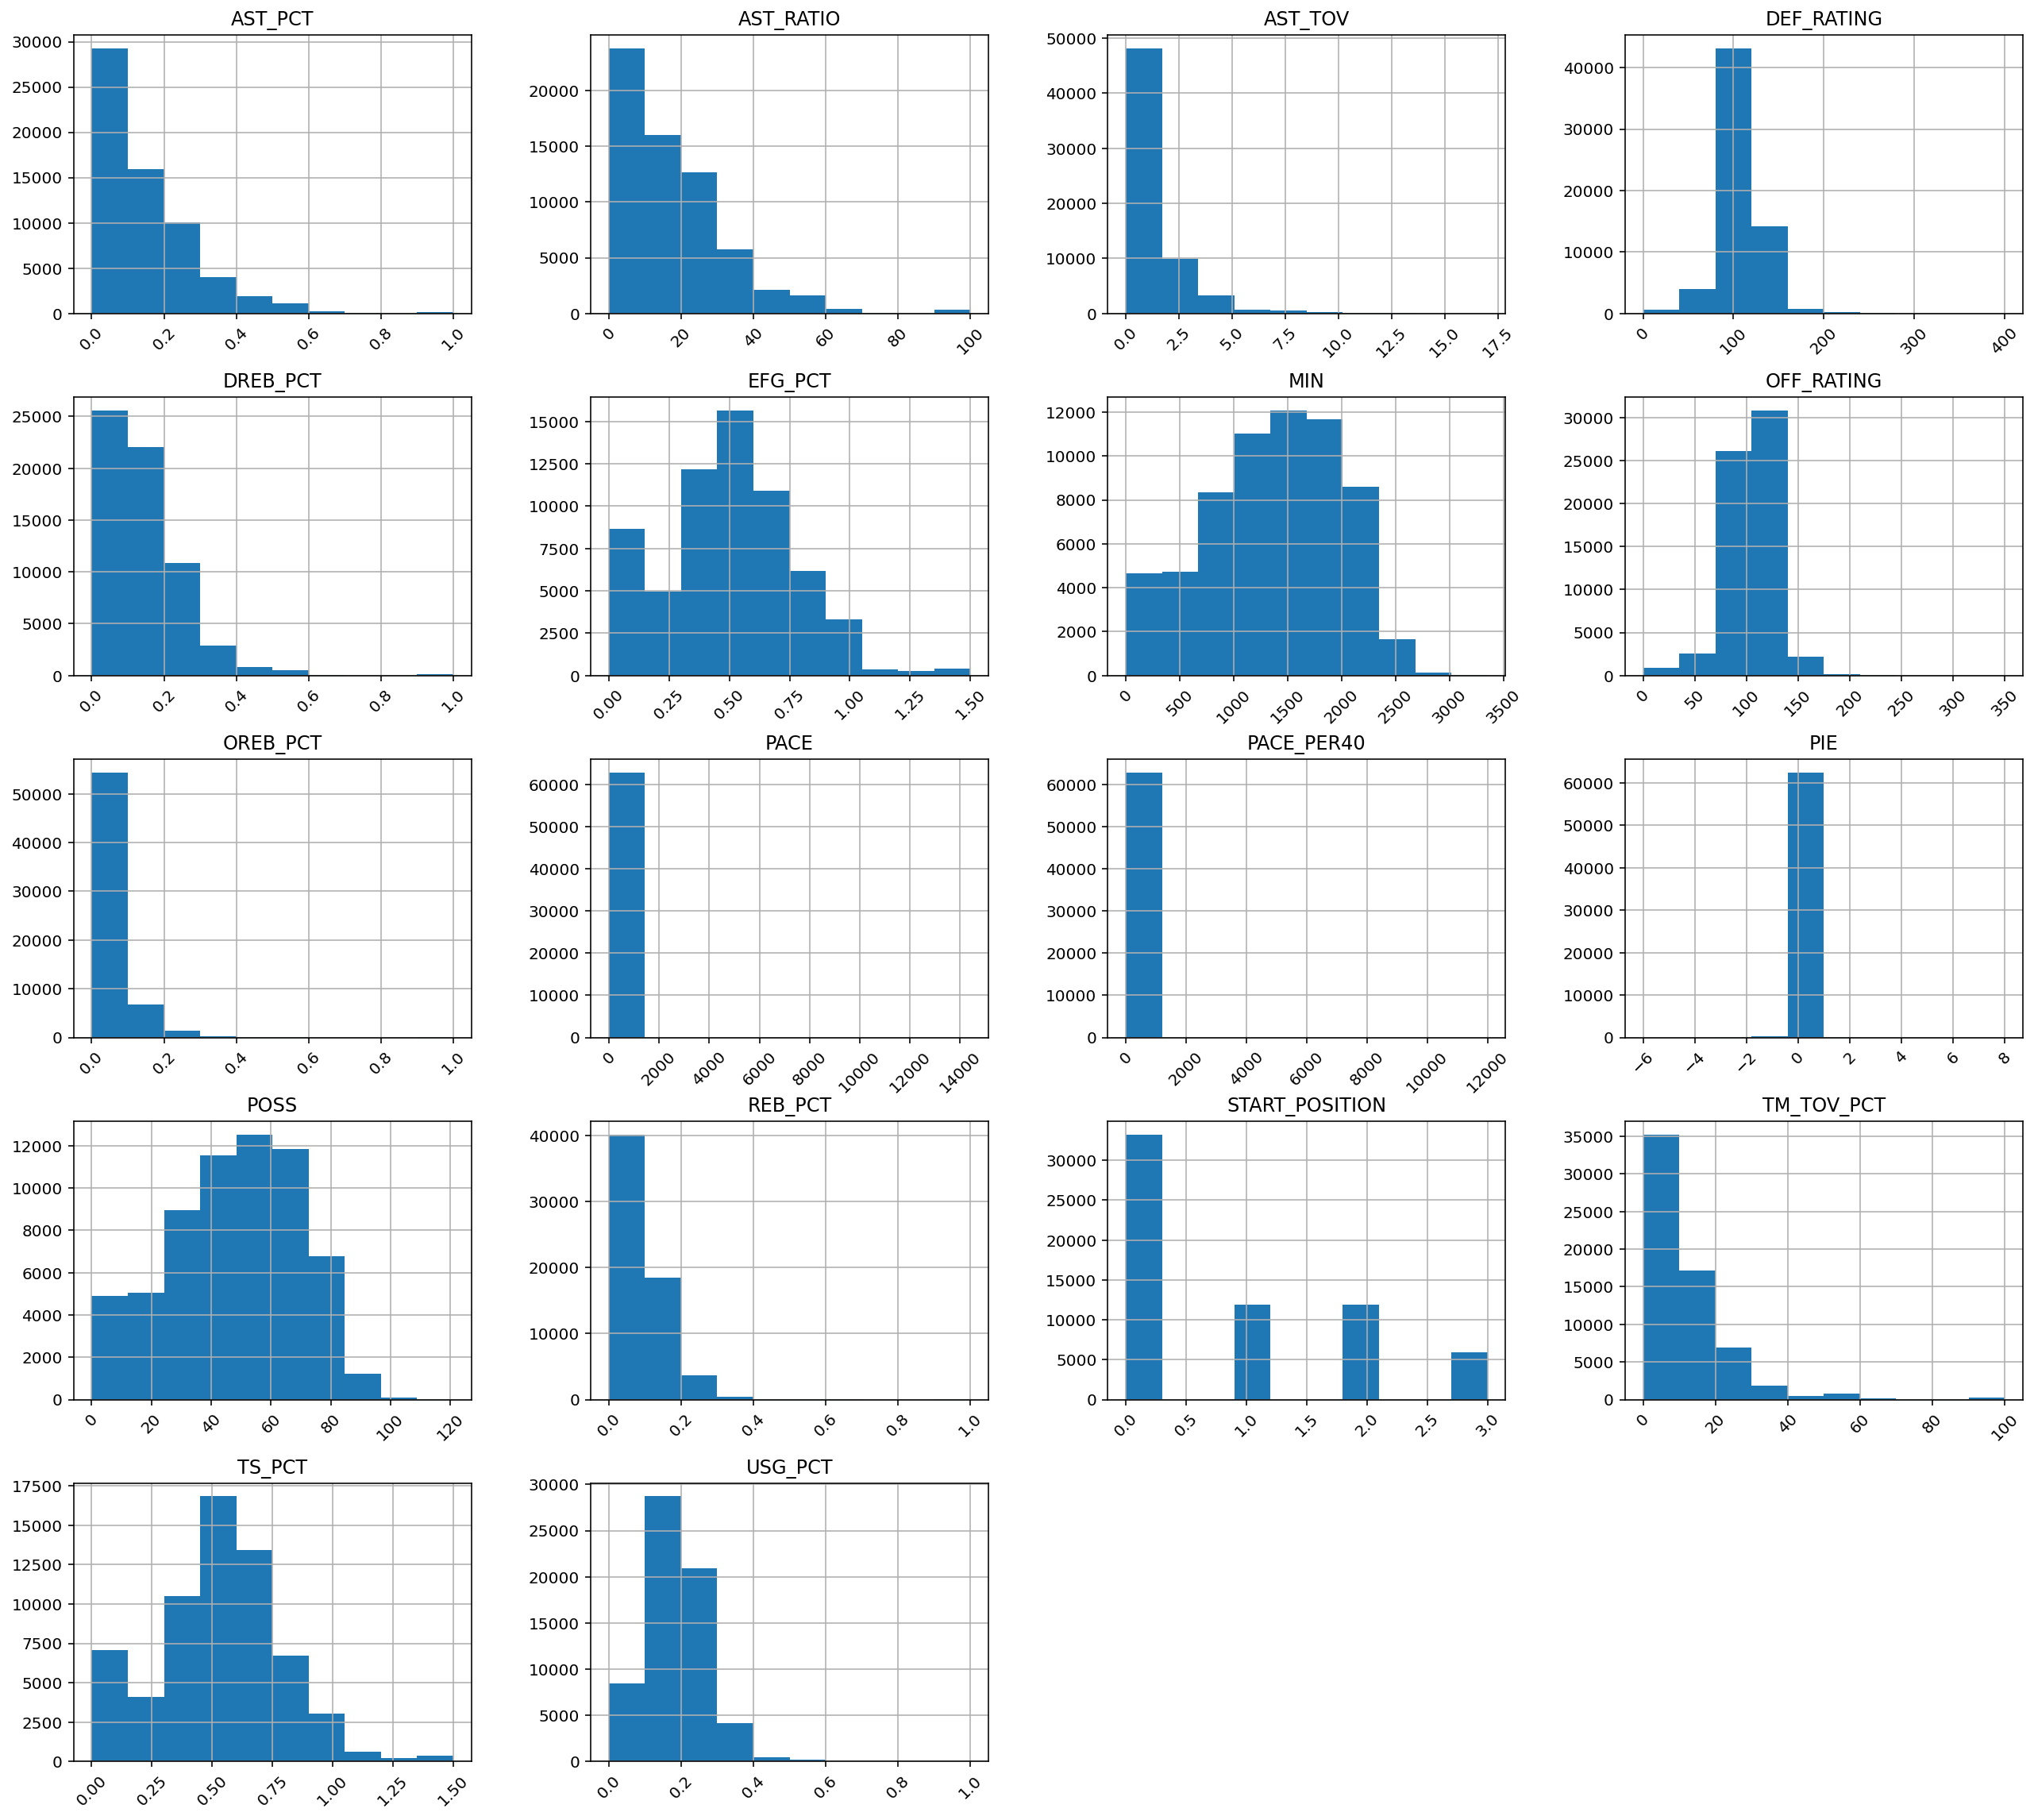

In [16]:
# Inspect distributions
plays_df[features].hist(figsize=(22, 20), xrot=45, sharey=False)
plt.show()

At first, we can confirm that all the boundaries make sense - no incorrect values are captured in either side of both axes. Next we look for possible outliers. We note that `PACE` and `PACE_40` have potential outliers to the right, whereas `PIE` may have in either of the sides. Finally, most of the features are right-skewed, incl. `AST_PCT`, `AST_TOV`, `AST_RATIO`, `OREB_PCT`, `DREB_PCT`, `REB_PCT`, `TM_TOV_PCT`, `PACE` and `PACE_40`.

## 4.2 Summary Statistics

In [17]:
plays_df[features].describe()

,START_POSITION,MIN,OFF_RATING,DEF_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,PACE,PACE_PER40,POSS,PIE
count,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000
mean,0.848012,1365.656671,104.810268,107.299081,0.138187,1.037766,16.197189,0.040010,0.136368,0.088292,10.242790,0.487106,0.519022,0.184114,103.341069,86.117551,47.786987,0.088271
std,1.034959,613.196751,23.251576,23.058018,0.140800,1.579515,15.515182,0.060202,0.110823,0.069152,12.341289,0.281903,0.270811,0.083798,104.927575,87.439643,21.401744,0.163042
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000
25%,0.000000,935.000000,93.800000,95.700000,0.000000,0.000000,0.000000,0.000000,0.061000,0.042000,0.000000,0.333000,0.375000,0.130000,96.610000,80.510000,33.000000,0.036000
50%,0.000000,1416.000000,106.300000,107.100000,0.111000,0.330000,14.300000,0.000000,0.120000,0.077000,8.300000,0.500000,0.532000,0.180000,100.880000,84.060000,50.000000,0.089000
75%,2.000000,1852.000000,118.200000,119.200000,0.208000,1.500000,25.000000,0.061000,0.192000,0.123000,15.400000,0.667000,0.680000,0.235000,105.520000,87.930000,65.000000,0.143000
max,3.000000,3350.000000,350.000000,400.000000,1.000000,17.000000,100.000000,1.000000,1.000000,1.000000,100.000000,1.500000,1.500000,1.000000,14405.760000,12004.800000,121.000000,8.000000


*(We ignore the `START_POSITION` at this part, as it is encoded to the numerical form).*

Not much to be mentioned here, as the dataset was originally of high quality (nba_api) and the cleaning/pre-processing part has already been done. Having said that, no null values are present (`count`), all features begin from zero value (`min`) and each feature's variation (`std`) is at the same scale with the pertinent mean. The only worthmentioning finding is that the `PACE` and `PACE_40` columns note a remarkable range (from 0.0) to 14405.76 and 12004.8, respectively).
## 4.3 Correlations Matrix
A correlation is a value between -1 and 1 that amounts to how closely values of two separate features move simultaneously. It can be either positive - as one feature increases the other one also increases or negative - one feature increases as the other decreases. Correlations close to 0 indicate a weak relationship, while closer to -1 or 1 a strong relationship.

In [18]:
# at first, we switch to the numerical features
num_fts = features.copy()
num_fts.remove('START_POSITION')

In [19]:
corrs = plays_df[num_fts].corr()
corrs

,MIN,OFF_RATING,DEF_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,PACE,PACE_PER40,POSS,PIE
MIN,1.000000,0.269492,0.025755,0.191709,0.374058,0.104015,-0.017350,0.034493,0.018306,-0.036394,0.252412,0.266487,0.266491,-0.054220,-0.054220,0.989346,0.162604
OFF_RATING,0.269492,1.000000,0.017810,0.089484,0.164222,0.195823,0.092575,0.036426,0.103000,-0.134361,0.354712,0.369359,0.072085,-0.075579,-0.075579,0.258141,0.188756
DEF_RATING,0.025755,0.017810,1.000000,0.010697,0.006912,0.011426,0.005031,-0.057112,-0.082826,0.013075,0.017340,0.015528,0.007154,-0.067116,-0.067117,0.020461,-0.126710
AST_PCT,0.191709,0.089484,0.010697,1.000000,0.523028,0.735702,-0.056869,-0.001730,-0.023338,-0.044658,0.024880,0.038218,0.237225,-0.019558,-0.019558,0.192219,0.169358
AST_TOV,0.374058,0.164222,0.006912,0.523028,1.000000,0.418400,-0.054536,-0.007440,-0.025795,-0.003970,0.066483,0.077458,0.160746,-0.015656,-0.015656,0.372517,0.111191
AST_RATIO,0.104015,0.195823,0.011426,0.735702,0.418400,1.000000,-0.082276,-0.026763,-0.048963,-0.099170,-0.021042,-0.019480,-0.187564,-0.021870,-0.021870,0.101810,0.088196
OREB_PCT,-0.017350,0.092575,0.005031,-0.056869,-0.054536,-0.082276,1.000000,0.200340,0.592885,0.019416,0.082997,0.084413,0.098691,-0.016369,-0.016369,-0.024184,0.116670
DREB_PCT,0.034493,0.036426,-0.057112,-0.001730,-0.007440,-0.026763,0.200340,1.000000,0.861139,0.060996,0.057932,0.064709,0.072804,-0.020509,-0.020509,0.036994,0.217748
REB_PCT,0.018306,0.103000,-0.082826,-0.023338,-0.025795,-0.048963,0.592885,0.861139,1.000000,0.066793,0.100844,0.107668,0.102686,-0.023035,-0.023035,0.017050,0.239476
TM_TOV_PCT,-0.036394,-0.134361,0.013075,-0.044658,-0.003970,-0.099170,0.019416,0.060996,0.066793,1.000000,-0.020112,-0.021182,0.101378,-0.010043,-0.010043,-0.028742,-0.126418


Hard as it gets to reason on the table effectively, we are going to plot a heatmap, where:
- a high positive correlation appears as dark red
- a high negative correlation as dark blue
- closer to white signifies a weak relationship

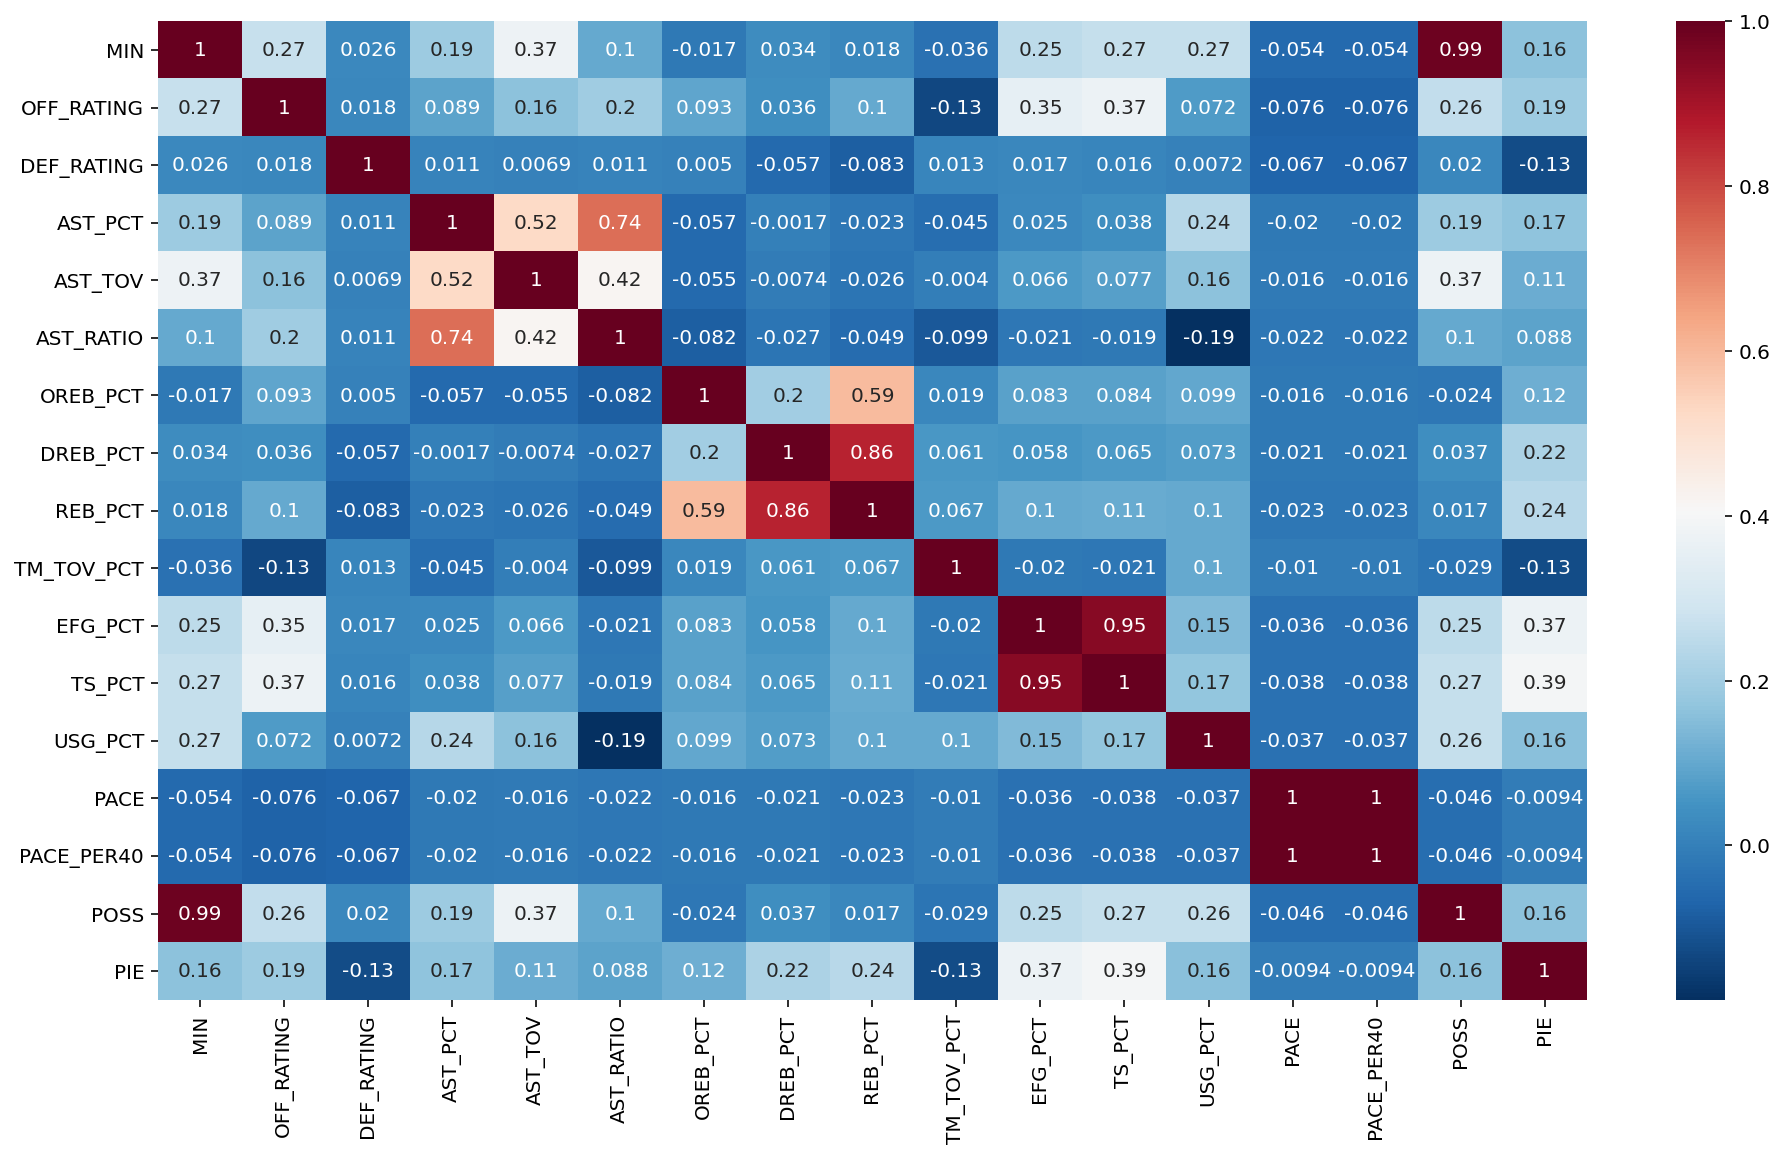

In [20]:
# heatmap
plt.figure(figsize=(16, 9))
sns.heatmap(corrs, cmap='RdBu_r', annot=True)
plt.show()

From this point of view, we note that:
1. `PACE_PER40` ~ `PACE` | `TS_PCT` ~ `EFG_PCT` | `REB_PCT` ~ `DREB_PCT` | `AST_RATIO` ~ `AST_PCT` note the stronger positive correlation
2. `USG_PCT` ~ `AST_RATIO` | `TM_TOV_PCT` ~ `OFF_RATING` note the stronger negative correlation

# 5 Inferences
## 5.1 Intuition Building
In this part we have to build intuition on what is really important when it comes to access a **Shooting Guard**. In this context, we classify the features from the least to the most important ones, based on domain knowledge and in order to make it viable to take the final decision.

The following code block depicts the assessment we opt, where the `OFF_RATING` `AST_PCT`, `AST_TOV`, `TM_TOV_PCT`, `EFG_PCT`, `TS_PCT` & `POSS` take the lead.

In [21]:
# classify features by domain importance
group_1 = ['OFF_RATING', 'AST_PCT', 'AST_TOV',
           'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'POSS']
group_2 = ['MIN', 'AST_RATIO', 'DREB_PCT']
group_3 = ['OREB_PCT', 'REB_PCT', 'USG_PCT', 'PACE', 'PACE_PER40', 'PIE']
group_4 = ['START_POSITION']
group_5 = ['DEF_RATING']

## 5.2 Grouping
All the variables are measured on the ratio scale, thus we can leverage box plots. Whiskers Box Plots, when compared to the respective histogram, give us a good visual intuition about the proportion of values that fall under a certain quartile, between any two quartiles, or between a quartile and the minimum or the maximum value in the distribution.

In [22]:
data = plays_df[features]
data

,START_POSITION,MIN,OFF_RATING,DEF_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,PACE,PACE_PER40,POSS,PIE
0,2,2259,111.3,121.3,0.152,5.00,33.3,0.023,0.156,0.079,6.7,0.444,0.444,0.109,101.99,84.99,80,0.063
1,2,1997,127.4,119.7,0.031,0.00,7.7,0.079,0.200,0.127,0.0,0.542,0.542,0.141,103.84,86.53,73,0.064
2,3,1090,95.1,155.0,0.000,0.00,0.0,0.050,0.250,0.125,16.7,0.600,0.575,0.267,107.01,89.17,41,0.092
3,1,2184,126.0,124.7,0.440,3.67,28.2,0.024,0.185,0.088,7.7,0.522,0.545,0.308,101.54,84.62,77,0.134
4,1,1984,111.0,130.6,0.323,10.00,50.0,0.029,0.259,0.129,5.0,0.222,0.222,0.123,105.24,87.70,73,0.068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74501,0,1155,92.5,104.9,0.000,0.00,0.0,0.000,0.038,0.020,0.0,0.250,0.410,0.104,100.99,84.16,40,0.016
74502,0,1869,107.6,98.5,0.235,1.33,15.4,0.056,0.116,0.089,11.5,0.471,0.533,0.278,102.47,85.39,66,0.154
74503,0,739,70.4,121.4,0.000,0.00,0.0,0.000,0.167,0.081,14.3,0.000,0.170,0.206,107.17,89.31,27,-0.039
74504,0,472,94.1,118.8,0.000,0.00,0.0,0.000,0.000,0.000,0.0,0.500,0.500,0.100,100.68,83.90,17,0.049


We narrow our investigation to the most significant group of features, i.e. `group_1` and in order to better depict the distribution, we partially visualize features of the same range.

In [23]:
data[group_1].describe()

,OFF_RATING,AST_PCT,AST_TOV,TM_TOV_PCT,EFG_PCT,TS_PCT,POSS
count,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000
mean,104.810268,0.138187,1.037766,10.242790,0.487106,0.519022,47.786987
std,23.251576,0.140800,1.579515,12.341289,0.281903,0.270811,21.401744
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,93.800000,0.000000,0.000000,0.000000,0.333000,0.375000,33.000000
50%,106.300000,0.111000,0.330000,8.300000,0.500000,0.532000,50.000000
75%,118.200000,0.208000,1.500000,15.400000,0.667000,0.680000,65.000000
max,350.000000,1.000000,17.000000,100.000000,1.500000,1.500000,121.000000


In [24]:
# classify features by range/outliers
set_1 = ['OFF_RATING', 'TM_TOV_PCT', 'POSS']
set_2 = ['AST_PCT', 'EFG_PCT', 'TS_PCT']
set_3 = ['AST_TOV']

In [25]:
# Visualizing scatter plots

def visualize_df_box_plot(df, title):
    """
    Takes in a dataframe and the title of the plot.
    It returns a Whiskers Box Plot.
    Parameters
    ---------
    df           : a dataframe object
             Represents the dataframe to be depicted
    title        : a string
             Passes the title of the plot
    Returns
    -------
    plot : plot
            A Box plot
    """
    with plt.style.context("fivethirtyeight"):
        df.boxplot(
            vert=False,
            figsize=(13, 6),
            showfliers=True,
            showmeans=True,
            patch_artist=True,
            boxprops=dict(linestyle="-", linewidth=1.5),
            flierprops=dict(linestyle="-", linewidth=1.5),
            medianprops=dict(linestyle="-", linewidth=1.5),
            whiskerprops=dict(linestyle="-", linewidth=1.5),
            capprops=dict(linestyle="-", linewidth=1.5),
        )
        plt.title(title, fontsize=16, fontweight="heavy")
        plt.show()

In [26]:
def visualize_s_box_plot(s, title):
    """
    Takes in a pd.Series and the title of the plot.
    It returns a Whiskers Box Plot.
    Parameters
    ---------
    series       : a Series object
             Represents the pd.Series to be depicted
    title        : a string
             Passes the title of the plot
    Returns
    -------
    plot : plot
            A Box plot
    """
    with plt.style.context("fivethirtyeight"):
        s.plot.box(
            vert=False,
            figsize=(13, 4),
            showfliers=True,
            showmeans=True,
            patch_artist=True,
            boxprops=dict(linestyle="-", linewidth=1.5),
            flierprops=dict(linestyle="-", linewidth=1.5),
            medianprops=dict(linestyle="-", linewidth=1.5),
            whiskerprops=dict(linestyle="-", linewidth=1.5),
            capprops=dict(linestyle="-", linewidth=1.5),
        )
        plt.title(title, fontsize=16, fontweight="heavy")
        plt.show()

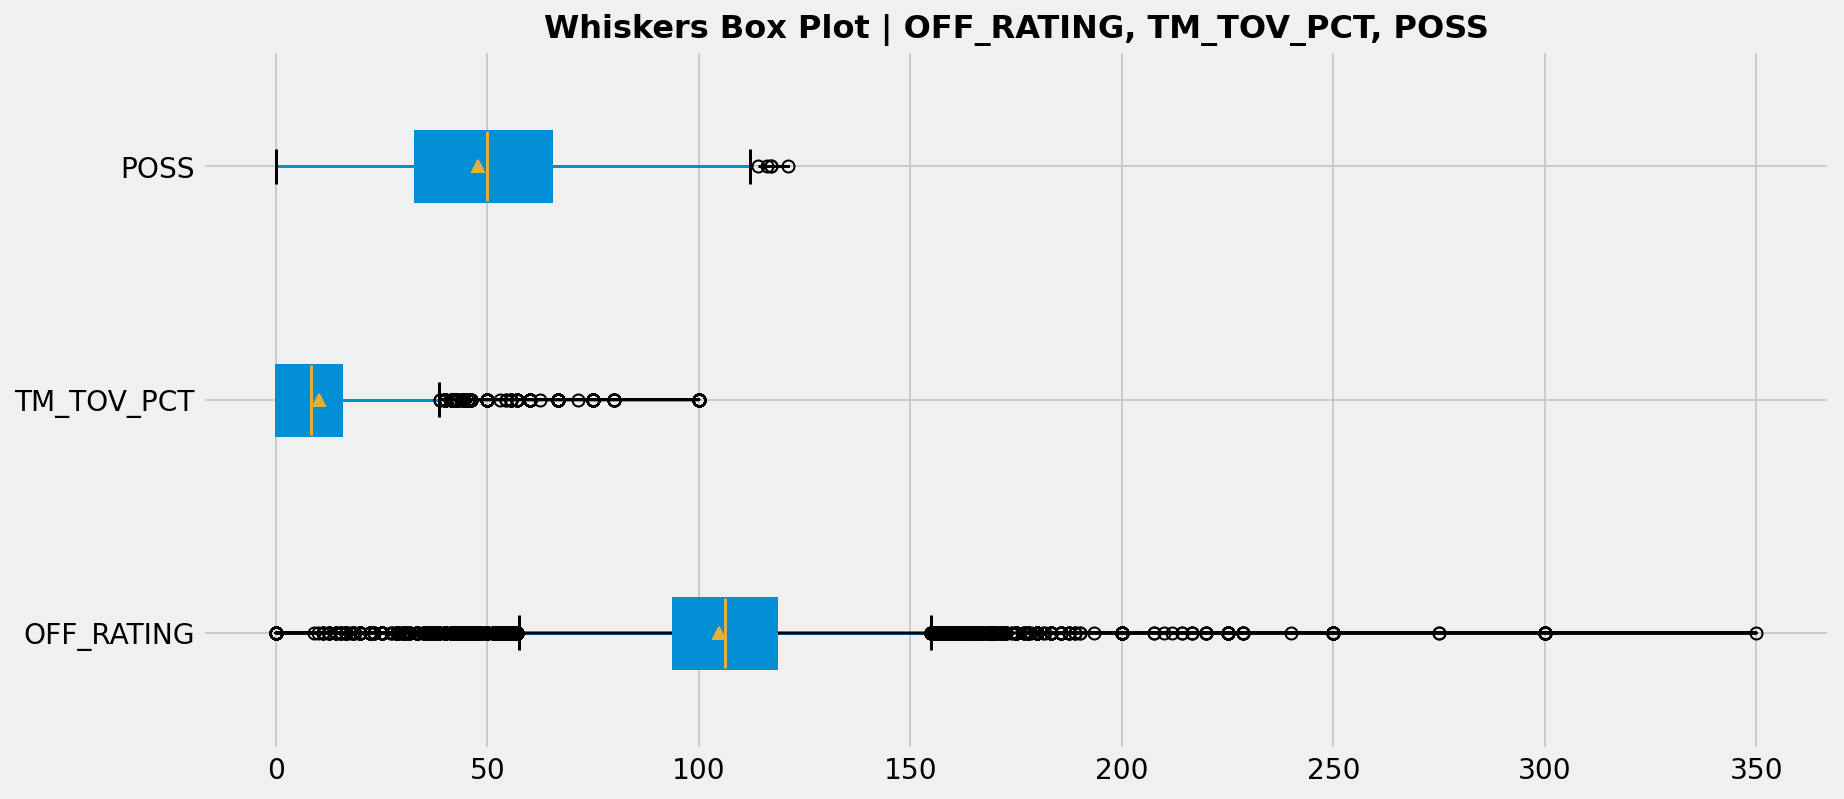

In [27]:
visualize_df_box_plot(data[set_1], 'Whiskers Box Plot | OFF_RATING, TM_TOV_PCT, POSS')

As expected all the variables begin from the 0 point. In addition, they all have outliers, which means either:
1. values > upper quartile by 1.5 * IR (interquartile range - ddifference between the upper quartile - lower quartile)
2. values < lower than the lower quartile by 1.5 * IR

* The `OFF_RATING` variable is mostly affected by outliers. The Lower/upper bounds are approx. 90/130, yet the min/max values are 0.0/350! Moreover, it is slightly left-skewed, with the Mean (yellow ▲) counting for 104.81, while the Median (red line) for 106.3.

* `TM_TOV_PCT` is mostly affected by outliers beyond the upper quartile 15.4 (75%), which reach the level of 100. The distribution is right-skewed as the Median is located to the left of the Mean.

* `POSS` is, also, affected by upper outliers. The upper bound is approx. 105, with the outliers reaching the point of 121. Similarly, to the case of `OFF_RATING`, the distribution is slighlty left-skewed, where the Mean is located to the left-most of the Median.

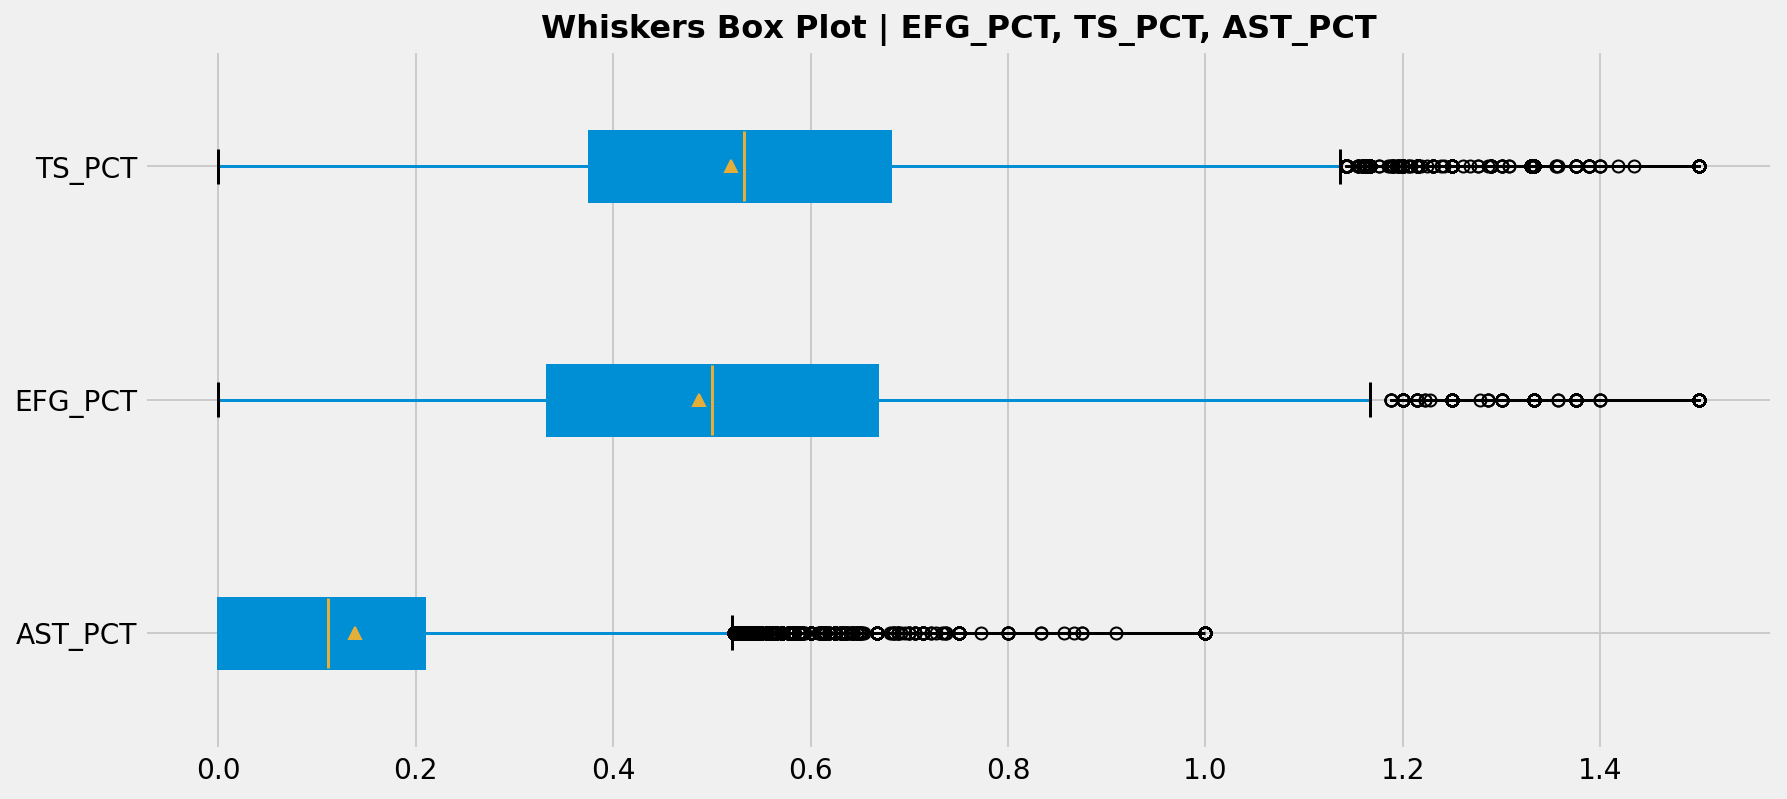

In [28]:
visualize_df_box_plot(data[set_2], 'Whiskers Box Plot | EFG_PCT, TS_PCT, AST_PCT')

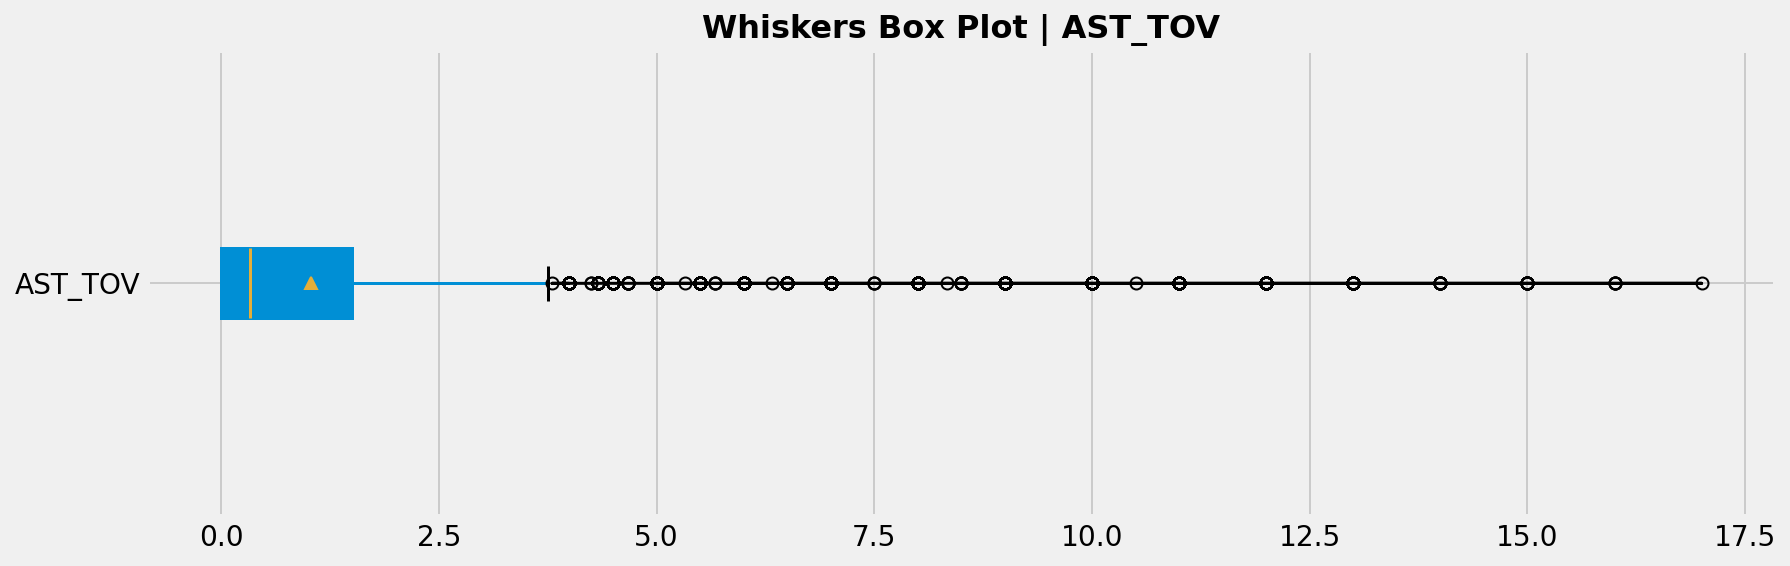

In [29]:
visualize_s_box_plot(data[set_3], 'Whiskers Box Plot | AST_TOV')

In [30]:
data[group_1].describe()

,OFF_RATING,AST_PCT,AST_TOV,TM_TOV_PCT,EFG_PCT,TS_PCT,POSS
count,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000
mean,104.810268,0.138187,1.037766,10.242790,0.487106,0.519022,47.786987
std,23.251576,0.140800,1.579515,12.341289,0.281903,0.270811,21.401744
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,93.800000,0.000000,0.000000,0.000000,0.333000,0.375000,33.000000
50%,106.300000,0.111000,0.330000,8.300000,0.500000,0.532000,50.000000
75%,118.200000,0.208000,1.500000,15.400000,0.667000,0.680000,65.000000
max,350.000000,1.000000,17.000000,100.000000,1.500000,1.500000,121.000000


Again, as was expected, all the variables begin from the 0 point. In addition, they all have outliers.

* The `TS_PCT` variable is mostly affected by upper outliers, which level at 1.5 and it is left-skewed, as the Mean (0.52) is lower than the Median (0.53).

* The same applies in the case of `EFG_PCT`. It is left-skewed, with the upper bound leveling at apprx. 1.18 and the max value reaching the level of 1.5.

* `AST_PCT` begins from the 0 point slightly before the level of the 2nd quartile! It is right skewed, affected by upper outliers which level to the point of 1.0.

* As for the `AST_TOV`, it has a great span of upper outliers, who begin from the point of 3.2 and reach the level of 17.0. It is right-skewed.

## 5.3 Quest for Best Shooting Guard
Relying only on plain EDA and visual demonstration of the dataset, we are going to find patterns that defines the optimum player for that position.

The most profound way is to group them in such a manner that the most essential features are maximised. But... All those features belonging to the aforementioned groups (`group_1` ... `group_5`) are important. Except from the `START_POSITION` (ALREADY EXPLAINED) and the `DEF_RATING` which has negative impact (less is better), the rest of them have to be maximised.

To be more concise, we will narrow the investigation to the `group_1` features only and make an attempt. Particularly, we let the `AST_PCT` to take the lead, sort the dataset by that to fetch the best samples and reflect on the findings...

In [31]:
plays_df.loc[plays_df['AST_PCT'] > plays_df['AST_PCT'].quantile(0.95), group_1].describe()

,OFF_RATING,AST_PCT,AST_TOV,TM_TOV_PCT,EFG_PCT,TS_PCT,POSS
count,3056.000000,3056.000000,3056.000000,3056.000000,3056.000000,3056.000000,3056.000000
mean,104.781872,0.527235,2.929741,9.501309,0.472252,0.509817,48.632199
std,23.812656,0.142249,2.974245,8.700416,0.274866,0.267038,25.562033
min,22.200000,0.406000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,93.000000,0.440000,0.000000,0.000000,0.333000,0.383000,28.000000
50%,105.900000,0.500000,2.310000,8.700000,0.500000,0.532000,53.000000
75%,118.200000,0.545000,4.000000,14.300000,0.625000,0.666000,70.000000
max,250.000000,1.000000,17.000000,66.700000,1.500000,1.500000,121.000000


In [33]:
plays_df[group_1].describe()

,OFF_RATING,AST_PCT,AST_TOV,TM_TOV_PCT,EFG_PCT,TS_PCT,POSS
count,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000,62893.000000
mean,104.810268,0.138187,1.037766,10.242790,0.487106,0.519022,47.786987
std,23.251576,0.140800,1.579515,12.341289,0.281903,0.270811,21.401744
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,93.800000,0.000000,0.000000,0.000000,0.333000,0.375000,33.000000
50%,106.300000,0.111000,0.330000,8.300000,0.500000,0.532000,50.000000
75%,118.200000,0.208000,1.500000,15.400000,0.667000,0.680000,65.000000
max,350.000000,1.000000,17.000000,100.000000,1.500000,1.500000,121.000000


The sample Mean for `AST_PCT` is almost 0.53, way above the population one (0.14)! But, the same does not apply for many other features... For instance, the average `TM_TOV_PCT` is now lower than the whole dataset's (9.5 < 10.24), similarly to the `EFG_PCT`. In other words, taking into account one or two features to guide us through the procedure by making most of them, compromises the other ones and the result is not robust. You would not like to sign a Shooting Guard of great Assists Count but poor field goal percentage (`EFG_PCT`)!

# 6. Conclusion
All the features are of high quality in terms of null presence, duplicated samples or low-variance. Moreover, their boundaries make sense, without any suspicious case of unreasonable extreme values.

However, many of them contain outliers to either of the sides. This is quite anticipated, as we deal with real game plays and not all the players (even the same one in different games) can always perform within a fixed perfromance 'bracket'.

As far as the crucial set of features (aka `group_1`) is concerned, they are almost balanced between left/right-skewed. Howbeit, the crucial factor that holds is the great presence of outliers beyond the pertinent upper boundary. Id est, there are many players that oftentimes perform well above the expectations and this fact comes in line with our intuition; deeply studying them in a way that not only will guarantee significant levels for those features, but also wont compromise (the best possible) the rest...

With that in mind, we iniated a naive approach of sorting the dataset by a master feature (`AST_PCT`), taking the upper segment of it and evaluate the plays 'horizontally' (along all the features). The outcome was dissapointing, as by maximizing along one feature, many of the rest get worse.

**All in all, it gets easily conceived that we cannot figure out the best 'plays' in order to build the profile of the suitable player to buy. With that in mind, we have to build better intuition on the existent data and use more advanced techniques, to effectively segment it and capture the underlying patterns, which may lead us to the best player.**

Clustering it is! Switch to the `01_clustering[kmeans_GMM].ipynb` notebook to take action.

In [34]:
# export the processed dataset
plays_df.to_csv('../notebooks/plays_17_18_19_pre_proc_train.csv', index=False)